<h1>HLS Video Demo: Sobel Filter</h1>

<p>This is a quick example running the HLS framebuffer logicore IP's with a Sobel filter in between input and output. Use this with either image or webcam input. Updated from VDMA IP in Pynq framework to using HLS framebuffers for simpler interface.</p>

<h3>Overview of HLS Sobel Filter</h3>

<i>Using three main directives, the DATAFLOW, PIPELINE, and UNROLL functions</i>

<h4>2D Filter, generic block</h4>

```
void hls_2DFilter(G_IMAGE& input_mat, G_IMAGE& output_mat) {
	G_WINDOW IN_WINDOW;
	G_PIXEL ip_pixel;
	G_PIXEL sp_pixel;

	G_PIXEL line_buffer[width][FILTER_SIZE]; // line-buffers
	#pragma HLS ARRAY_PARTITION variable=line_buffer complete dim=2

	L1: for(int row = 0; row < height; row++)
	{
	L2: for(int col = 0; col < width; col++)
	{
#pragma HLS LOOP_FLATTEN off
#pragma HLS PIPELINE II=1

		input_mat >> ip_pixel;

		line_buffer[col][FILTER_SIZE-1] = ip_pixel;

		IN_WINDOW.shift_pixels_left();
		IN_WINDOW.insert_pixel(line_buffer[col][0], 0, 2);
		IN_WINDOW.insert_pixel(line_buffer[col][1], 1, 2);
		IN_WINDOW.insert_pixel(line_buffer[col][2], 2, 2);

		//This design assumes there are no edges on the boundary of the image
		if ( (row>=FILTER_OFFS) & (col>=FILTER_OFFS) & (row<height) & (col<width) )
			sp_pixel = sobel_operator(IN_WINDOW);
		else
			sp_pixel.val[0] = 0;

		output_mat << sp_pixel;

		for (int fil = 0; fil < FILTER_SIZE-1; fil++){
#pragma HLS UNROLL
			line_buffer[col][fil] = line_buffer[col][fil+1];
		}

	}
	}
}

```

<h4>Sobel Kernel</h4>

```
G_PIXEL sobel_operator(G_WINDOW& input_window){
	G_PIXEL temp_pixel;

	char kernelx[3][3] = { { -1, 0, 1 },
	    { -2, 0, 2 },
	    { -1, 0, 1 } };

	char kernely[3][3] = { { -1, -2, -1 },
		{ 0,  0,  0 },
		{ 1,  2,  1 } };

	char x_mag, y_mag;

	x_mag = 0;
	y_mag = 0;

	hor_conv: for (int rowOffset = -1; rowOffset <= 1; rowOffset++){
#pragma HLS UNROLL
		ver_conv: for (int colOffset = -1; colOffset <= 1; colOffset++){
#pragma HLS UNROLL
			temp_pixel = input_window.getval(1 + rowOffset, 1 + colOffset);
			x_mag = x_mag + (temp_pixel.val[0] * kernelx[1 + rowOffset][1 + colOffset]);
			y_mag = y_mag + (temp_pixel.val[0] * kernely[1 + rowOffset][1 + colOffset]);
		}
	}

	if ((hls::abs(x_mag) + hls::abs(y_mag)) > 125){
		return 255;
	} else {
		return 0;
	}

	return 0;

}
```

<p>After compiling the above functions into Vivado HLS, they can be exported as IP and used in your Vivado IP Integrator design.</p>

<h3>Import framebuffer utility class and load the bitstream</h3>
<p>The overlay class both loads the bitstream and parses the tcl file to find any blocks in the IPI diagram that have drivers. The framebuffer utility class creates simple drivers for the framebuffer read/write blocks so we'll get objects for each as described below.</p>

In [5]:
from fb_util import *
from pynq import PL
from pynq import Overlay
import cv2

ol = Overlay("sobel_thresh.bit")

<p>Querying this overlay shows the two framebuffers:

<b>
<ul style="list-style-type:square">
  <li>v_frmbuf_rd_0        : fb_util.FrmBufRd</li>
  <li>v_frmbuf_wr_0        : fb_util.FrmBufWr</li>
</ul>
</b>

We can set these up with the simple HLS data mover driver (Python based) as shown below, as well as declaring what the input width and height of the image are going to be.</p>

In [6]:
HLS_video = HLS_video_move(ol.v_frmbuf_rd_0, ol.v_frmbuf_wr_0, 1280, 720)

<h3>Fill the source data buffer and set the destination buffer</h3>
<p>When the HLS_video_move object is instantiated above, this uses a contiguous memory allocator to set up the memory space in DDR for the image. The openCV image read function is then used to transfer the image from the file into the source data contiguous memory.

After the buffer is filled, the framebuffer IP's are started to stream the image through the HLS block and back into the destination buffer.

While the framebuffers are streaming through the HLS Video IP block, a timer is started to get an idea of the first-pixel-in to last-pixel-out latency.
</p>

In [7]:
import time

img = cv2.imread('test_image.bmp')
HLS_video.source_array[:] = img

#Start the timer and the IP
start_time = time.perf_counter()
HLS_video.start_and_wait()
stop_time = time.perf_counter()

print("Conversion took %0.5f seconds" % (stop_time - start_time))

Conversion took 0.00288 seconds


<h3>Display the resulting image</h3>
<p>Now that the image has been streamed into the destination buffer, we can display the image with the matplotlib library. The contiguous memory allocation of the destination buffer is a subclass of a Numpy array, so we call imshow with the object of the array.</p>

<IPython.core.display.Javascript object>


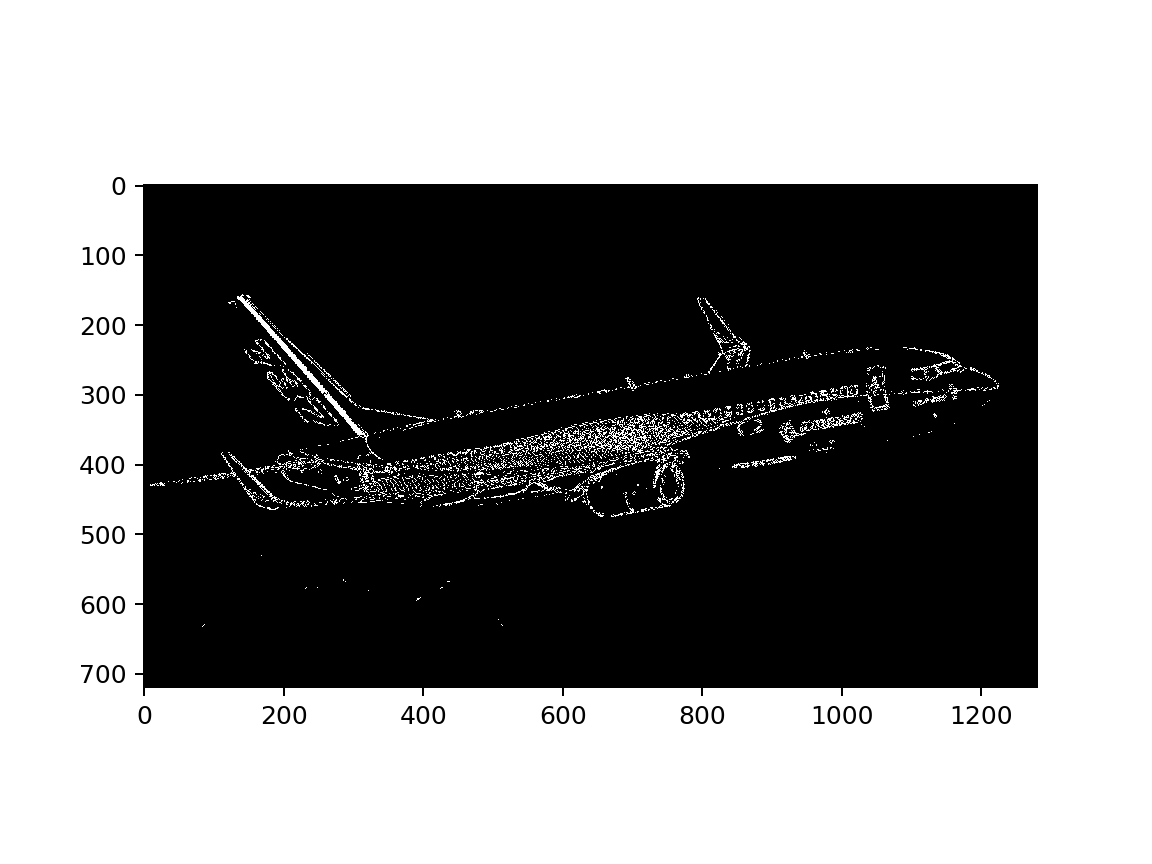

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure(dpi=150)
plt.imshow(HLS_video.dest_array)